Particle filtering to demodulate fake Kansas City Standard variant signals
===================

I've been [trying
some standard signal processing techniques in another notebook][0]
to demodulate data cassettes from the 80s
for the Sord M5 home computer
using a variant of the Kansas City Standard.
This did more or less work.
However, as I wrote in pavnotes2,
it occurred to me that particle filters might work better.

[0]: ./kansas-city-demodulation.ipynb

Making a fake signal
---------

Here's the code from that other notebook that produces a fake
signal.  This signal is not realistic in several ways:

- the speed is precisely correct and constant;
- it is very short (5 bytes);
- it contains harmonic frequencies extending smoothly to Nyquist,
  while real cassette tape systems have a significant lowpass
  characteristic, especially after the tape has been played
  many times;
- the amplitude is precisely constant; and
- the noise level is about 100x higher than on real cassettes
  which have typically about 40 or 50 dB of SNR, while this
  signal has only 20 dB.

In [1]:
%pylab inline
rcParams['figure.figsize'] = (12, 2)
rcParams['lines.linewidth'] = 0.5

Populating the interactive namespace from numpy and matplotlib


(419.84580498866296, 4.2527661764794775)

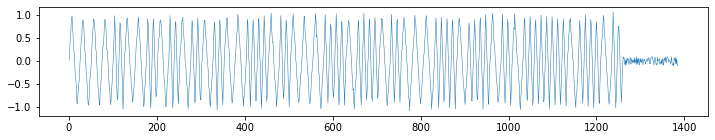

In [2]:
fs = 44100   # sampling frequency
f0 = 1750    # frequency of a 0 bit
tb = 1/f0    # time of a bit
sb = fs * tb # samples of a bit
def triw(t):  # t is a fraction from 0.0 to 1.0 indicating where we are in the cycle
    return abs(abs(4*t - 1) - 2) - 1
message = 'Hello'
msgary = array([ord(c) for c in message])
n_start_bits = 1
stop_bits = 1 << 8 + n_start_bits
bits = (right_shift.outer(msgary << n_start_bits | stop_bits,
                          arange(10))) & 1
br = bits.ravel()
n_samples = int(len(br) * sb)
bitidx, phase = divmod(arange(n_samples), sb)
bi = bitidx.astype(int)    # bit index
bf = br[bi] + 1            # bit frequency
omega = phase * bf / sb % 1
noise = .2 * (random.random(round(len(omega) * 1.1)) - 0.5)
clean_signal = triw(omega)
signal = noise.copy()
signal[:len(clean_signal)] += clean_signal
plot(signal)
(clean_signal**2).sum(), (noise[:len(clean_signal)]**2).sum()

I'm pretty confident the LTI filtering in the other notebook
isn't keying off this high-frequency content,
but I'm not sure I can make the same assurance
about the particle-filter stuff I want to try here.
So I'd like to lowpass filter to get a better approximation
of a real tape signal.

The dumbest possible way to get a lowpass filter
is just cumsum,
which unfortunately has a pole at dc;
in this case this is conspicuously visible
but less problematic than
the fact that this filter already has a dramatic rolloff
between our two carrier frequencies:

53

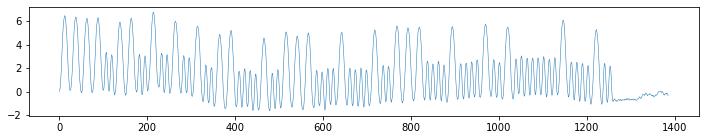

In [3]:
plot(signal.cumsum())
53

A very slightly less dumb approach is to convolve the signal with
some kind of low-pass filter kernel.  [Cassette tapes
are reported to have fairly flat response up to at least 2kHz][1]
and sometimes 15kHz, though I suspect that's under
idealized conditions like not being played dozens of times
and then stored for 40 years.
I tried picking a kernel width based on that information,
but it was far too aggressive, badly attenuating
the higher carrier frequency, so instead
I fiddled with the width parameter here until the time-domain signal
looked about right.

[1]: https://commons.wikimedia.org/wiki/File:BiasEffectOnCassetteTapeFrequencyResponse.png

4524.8385506292725

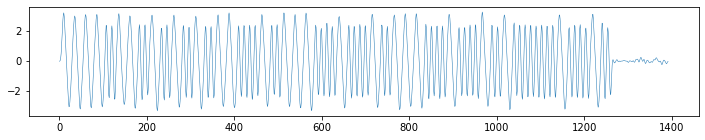

In [4]:
sf = convolve(signal, hamming(8))
plot(sf)
(sf**2).sum()

Just in case, let's see what that kernel's frequency response is.

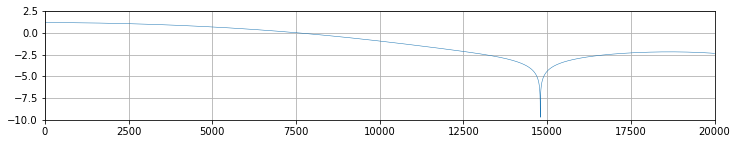

In [5]:
plot(log10(abs(fft.fft(concatenate((hamming(8), zeros(44100-8)))))**2))
xlim(0, 20000)
ylim(-10, 2.5)
grid(True)

Well, that looks almost, but not quite, completely unlike
thé cassette tape response curves from Wikipedia.
In particular, it's only attenuated the signal by about 5dB
at 10kHz, and only 7dB at 18kHz.  So even though the two carriers
have about the right relative amplitudes,
this signal still contains a lot more high-frequency information
than a real signal.

Fake signal, say hello to my little friend:

In [6]:
import scipy.signal
scipy.signal.iirfilter

<function scipy.signal.filter_design.iirfilter(N, Wn, rp=None, rs=None, btype='band', analog=False, ftype='butter', output='ba', fs=None)>

In [7]:
b, a = scipy.signal.iirfilter(2, 6000, btype='lowpass', fs=44100)
b, a

(array([0.11205521, 0.22411041, 0.11205521]),
 array([ 1.        , -0.8559895 ,  0.30421033]))

In [8]:
scipy.signal.lfilter

<function scipy.signal.signaltools.lfilter(b, a, x, axis=-1, zi=None)>

array([ 0.00241963,  0.01789196,  0.07624299, ...,  0.00872898,
       -0.00800569, -0.0379871 ])

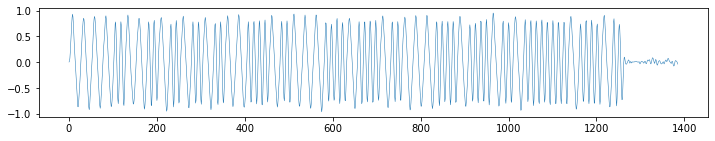

In [9]:
ifs = scipy.signal.lfilter(b, a, signal)
plot(ifs)
ifs

That again looks kind of reasonable in the time domain,
but so did the other filter;
let's see what our filter looks like
in the frequency domain.

(0, 22050)

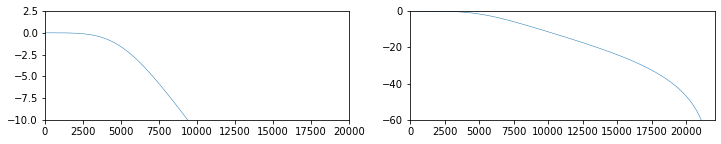

In [10]:
impulse = zeros(44100)
impulse[0] = 1
ff = abs(fft.fft(scipy.signal.lfilter(b, a, impulse)))**2 # filter freq
subplot(121); plot(log10(ff)*10); ylim(-10, 2.5); xlim(0, 20000)
subplot(122); plot(log10(ff)*10); ylim(-60, 0); xlim(0, 22050)

That Butterworth rolloff is, well,
far from a perfect approximation of cassette-tape characteristics,
but it does look a lot closer than the previous version.

Actual particle filtering
-----

Uh, soon.